<h1 style="text-align: center;">Tennis Analyzer ML Model V2</h1>
<h3 style="text-align: center;">Dan Warnick</h3>

<p>To start we will begin by selecting the data points we want to analyze with existing known results. For each data entry we will have two players each with the following data entries.</p>
<table style="font-size: .8em;">
    <tr>
        <th>Player Name</th>
    </tr>
</table>
<p>Along with match facts like Clay/Hard/Grass Court or Indoor/Outdoor. In the future may want to add weather and adjust certain parameters for more accuracy and more data points to train from, however for now this seems a good start.</p>

<h2>1.) Collect Data Efficiently</h2>

In [179]:
import django
from django.http import HttpResponse
from django.template import loader
import os
from django.db import models
import torch
from math import ceil, floor
import math
import numpy as np
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.utils as utils
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from datetime import datetime
from asgiref.sync import sync_to_async # type: ignore
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import copy
import joblib

# os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'breakpoint.settings')
# django.setup()

# from render.models import *

In [180]:
start = '20120101'
end = '20231231'
match_type = 'm'

In [181]:
start_date = datetime.strptime(start, '%Y%m%d').date()
end_date = datetime.strptime(end, '%Y%m%d').date()

# if match_type == 'm':   
#     typer = MensTennisMatch
#     insert_db = MensTennisMatchStats
# else:
#     typer = WomensTennisMatch
#     insert_db = WomensTennisMatchStats

# query = insert_db.objects.filter(
#         tourney_date__range=(start_date, end_date)
#     ).order_by('tourney_date')
    
# games = await sync_to_async(list)(query.all().values())

RD_CUTOFF = 125

df = pd.read_csv('../testcsvs/glickoUpdatedTest.csv')
df['tourney_date'] = pd.to_datetime(df['tourney_date']).dt.date
df = df[(df['tourney_date'] >= start_date) & (df['tourney_date'] <= end_date)]
df = df[(df['a_surface_glicko_rd'] <= RD_CUTOFF) & (df['b_surface_glicko_rd'] <= RD_CUTOFF) & (df['a_glicko_rd'] <= RD_CUTOFF) & (df['b_glicko_rd'] <= RD_CUTOFF)]


df = df.drop(['tourney_id', 'tourney_name', 'match_num', 'tourney_date', 'a_player_name', 'b_player_name', 'a_player_id', 'a_player_slug', 'b_player_id', 'b_player_slug', 'sets', 'games', 'tiebreaks'], axis=1)

one_hot_encoder = OneHotEncoder(sparse_output=False)

# One-Hot Encode the 'category_text' column
category_encoded = one_hot_encoder.fit_transform(df[['surface']])

# Convert to DataFrame
category_encoded_df = pd.DataFrame(category_encoded, columns=one_hot_encoder.get_feature_names_out(['surface']))

# Concatenate the one-hot encoded columns back to the original DataFrame
df = pd.concat([df, category_encoded_df], axis=1)

# Drop the original 'category_text' column
df.drop('surface', axis=1, inplace=True)
print(len(df))

32483


In [182]:
df.head()

,best_of,tourney_level,tourney_round,a_player_age,a_player_rank,a_player_rank_points,b_player_age,b_player_rank,b_player_rank_points,rank_diff,...,a_surface_return_second_won_glicko_rating,b_surface_second_won_glicko_rating,a_surface_return_second_won_glicko_rd,b_surface_second_won_glicko_rd,a_odds,b_odds,a_b_win,surface_Clay,surface_Grass,surface_Hard
5373,3.0,2.0,0.8,28.0,74.0,671.0,23.0,15.0,1925.0,59.0,...,1509.676357,1525.177533,64.968960,61.353283,3.59,1.28,0.0,0.0,0.0,1.0
5375,3.0,2.0,0.8,25.0,46.0,920.0,28.0,65.0,755.0,-19.0,...,1493.441526,1520.481105,70.605742,62.024125,NaN,NaN,0.0,0.0,0.0,1.0
5378,3.0,2.0,0.8,26.0,83.0,640.0,24.0,48.0,915.0,35.0,...,1506.545429,1507.882055,65.145579,63.927775,1.54,2.40,1.0,0.0,0.0,1.0
5381,3.0,2.0,0.8,27.0,38.0,1015.0,28.0,65.0,755.0,-27.0,...,1534.732931,1517.206849,62.140547,62.872428,NaN,NaN,1.0,0.0,0.0,1.0
5382,3.0,2.0,0.8,27.0,38.0,1015.0,29.0,57.0,828.0,-19.0,...,1535.923504,1494.807275,62.904123,66.485111,1.56,2.34,1.0,0.0,0.0,1.0


In [183]:
# Create a scatter plot
# df = df[~(df == 1500).any(axis=1)]
# plt.figure(figsize=(5, 5))

# # Plot a_elo_rating vs b_elo_rating for a_b_win == 1
# x1 = df[df['a_b_win'] == 1]['a_recent_elo_rating']
# y1 = df[df['a_b_win'] == 1]['b_recent_elo_rating']
# plt.scatter(x1, y1, color='blue', label='Favorite Wins', s=.5, alpha=0.5)

# # Plot b_elo_rating vs a_elo_rating for a_b_win == 0
# x2 = df[df['a_b_win'] == 0]['b_recent_elo_rating']
# y2 = df[df['a_b_win'] == 0]['a_recent_elo_rating']
# plt.scatter(x2, y2, color='orange', label='Upset', s=.5, alpha=0.5)

# # Combine data for a single trendline
# combined_x = np.concatenate([x1, x2])
# combined_y = np.concatenate([y1, y2])

# # Fit a polynomial of degree 2 to the combined data
# print(combined_x)
# coefficients = np.polyfit(combined_x, combined_y, 3)
# polynomial = np.poly1d(coefficients)
# trendline_x = np.linspace(combined_x.min(), combined_x.max(), 100)
# trendline_y = polynomial(trendline_x)
# plt.plot(trendline_x, trendline_y, color='green', linewidth=1, label='Quadratic Trendline')

# # Setting the limits for x and y axis
# plt.xlim(1100, 2300)
# plt.ylim(1100, 2300)

# # Adding labels and title
# plt.xlabel('ELO Rating Winner')
# plt.ylabel('ELO Rating Loser')
# plt.title('Scatter Plot of ELO Ratings based on Win/Loss')
# plt.grid(True)
# plt.legend()

# # Show the plot
# plt.show()

In [184]:
# plt.figure(figsize=(8, 5))

# df['elo_diff'] = df['a_recent_elo_rating']

# # Create bins for ELO difference in intervals of 10
# bins = np.arange(df['elo_diff'].min(), df['elo_diff'].max() + 10, 10)
# labels = (bins[:-1] + bins[1:]) / 2
# df['elo_diff_bin'] = pd.cut(df['elo_diff'], bins=bins, labels=labels, include_lowest=True)

# # Calculate average win rate at each ELO difference bin
# average_win_rate = df.groupby('elo_diff_bin')['a_b_win'].mean().reset_index()
# average_win_rate.columns = ['elo_diff_bin', 'avg_win_rate']

# # Convert the bin labels to numeric values
# average_win_rate['elo_diff_bin'] = average_win_rate['elo_diff_bin'].astype(float)

# average_win_rate = average_win_rate[~np.isnan(average_win_rate).any(axis=1)]

# # Create the scatter plot
# plt.scatter(average_win_rate['elo_diff_bin'], average_win_rate['avg_win_rate'], color='blue', label='Average Win Rate', s=10, alpha=0.5)

# # Fit a polynomial of degree 3 to the average win rate data
# coefficients = np.polyfit(average_win_rate['elo_diff_bin'], average_win_rate['avg_win_rate'], 5)
# polynomial = np.poly1d(coefficients)
# trendline_x = np.linspace(-600, 600, 100)
# trendline_y = polynomial(trendline_x)
# plt.plot(trendline_x, trendline_y, color='green', linewidth=1, label='Cubic Trendline')

# # Setting the limits for x and y axis
# plt.xlim(-600, 600)
# plt.ylim(0, 1)

# # Adding labels and title
# plt.xlabel('ELO Rating Difference (Winner - Loser)')
# plt.ylabel('Average Win Rate')
# plt.title('Scatter Plot of ELO Rating Difference vs. Win Rate')
# plt.grid(True)
# plt.legend()

# # Show the plot
# plt.show()

In [185]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [186]:
class ResidualBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.33)
        self.shortcut = nn.Linear(input_dim, hidden_dim) if input_dim != hidden_dim else nn.Identity()

    def forward(self, x):
        residual = self.shortcut(x)
        x = F.relu(self.bn(self.fc(x)))
        x = self.dropout(x)
        return x + residual

class OutcomeProbabilityV6(nn.Module):
    def __init__(self, input_dim=172, dropout_prob=0.33):
        hidden_dim1=input_dim * 2
        hidden_dim2=input_dim
        hidden_dim3=round(input_dim/2) 
        super(OutcomeProbabilityV6, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout_prob)
        
        self.res_block1 = ResidualBlock(hidden_dim1, hidden_dim1)
        self.res_block2 = ResidualBlock(hidden_dim1, hidden_dim2)
        self.res_block3 = ResidualBlock(hidden_dim2, hidden_dim3)
        
        self.fc4 = nn.Linear(hidden_dim3, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        
        x = self.sigmoid(self.fc4(x))
        return x

In [187]:
def train_and_evaluate(model, train_loader, val_loader, epochs=100, learning_rate=0.0001, weight_decay=1e-5, target_auc=0.75):
    loss_fn = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

    best_auc = -np.inf
    best_weights = None
    early_stopping_patience = 20
    early_stopping_counter = 0
    current_epoch = 0
    best_acc = 0.0

    while best_auc < target_auc and current_epoch < epochs:
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                val_loss += loss_fn(y_pred, y_batch).item() * X_batch.size(0)
                all_preds.append(y_pred.numpy())
                all_labels.append(y_batch.numpy())
                predicted = y_pred.round()
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)

        val_loss /= len(val_loader.dataset)
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        auc = roc_auc_score(all_labels, all_preds)
        acc = correct / total

        scheduler.step(val_loss)

        if auc > best_auc:
            best_auc = auc
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if (current_epoch + 1) % 10 == 0:
            print(f'Epoch [{current_epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, AUC: {auc:.4f}, Accuracy: {acc*100:.2f}%')

        current_epoch += 1

    model.load_state_dict(best_weights)
    return best_auc, best_acc, best_weights


In [188]:
def cross_validate(model_class, X, y, k=5, epochs=100, target_auc=0.75, learning_rate=0.0001, weight_decay=1e-5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    best_auc = -np.inf
    best_model_weights = None
    best_acc = 0.0

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train_fold, y_train_fold = X[train_idx], y[train_idx]
        X_val_fold, y_val_fold = X[val_idx], y[val_idx]

        X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_fold, dtype=torch.float32).view(-1, 1)
        X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val_fold, dtype=torch.float32).view(-1, 1)

        train_data = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
        val_data = TensorDataset(X_val_tensor, y_val_tensor)
        val_loader = DataLoader(val_data, batch_size=128, shuffle=False)

        model = model_class(input_dim=X.shape[1])
        auc, acc, model_weights = train_and_evaluate(model, train_loader, val_loader, epochs=epochs, learning_rate=learning_rate, weight_decay=weight_decay, target_auc=target_auc)

        if auc > best_auc:
            best_auc = auc
            best_acc = acc
            best_model_weights = model_weights

        print(f'Fold {fold + 1}/{k}, AUC: {auc:.4f}, Accuracy: {acc*100:.2f}%')

    return best_auc, best_acc, best_model_weights


9936
Fold 1/5, AUC: 0.8552, Accuracy: 76.54%
Epoch [10/100], Loss: 0.5247, Val Loss: 0.6015, AUC: 0.7662, Accuracy: 67.90%
Epoch [20/100], Loss: 0.5051, Val Loss: 0.6130, AUC: 0.7645, Accuracy: 67.49%
Epoch [30/100], Loss: 0.4899, Val Loss: 0.6085, AUC: 0.7654, Accuracy: 68.31%
Epoch [40/100], Loss: 0.5030, Val Loss: 0.6092, AUC: 0.7658, Accuracy: 68.31%
Epoch [50/100], Loss: 0.4982, Val Loss: 0.6081, AUC: 0.7658, Accuracy: 67.90%
Epoch [60/100], Loss: 0.5062, Val Loss: 0.6088, AUC: 0.7660, Accuracy: 68.31%
Epoch [70/100], Loss: 0.4940, Val Loss: 0.6082, AUC: 0.7656, Accuracy: 68.31%
Epoch [80/100], Loss: 0.4991, Val Loss: 0.6084, AUC: 0.7653, Accuracy: 68.31%
Epoch [90/100], Loss: 0.5204, Val Loss: 0.6123, AUC: 0.7660, Accuracy: 68.31%
Epoch [100/100], Loss: 0.5056, Val Loss: 0.6080, AUC: 0.7657, Accuracy: 67.90%
Fold 2/5, AUC: 0.7671, Accuracy: 68.31%
Epoch [10/100], Loss: 0.5265, Val Loss: 0.5068, AUC: 0.8248, Accuracy: 74.79%
Fold 3/5, AUC: 0.8253, Accuracy: 74.38%
Epoch [10/100], 

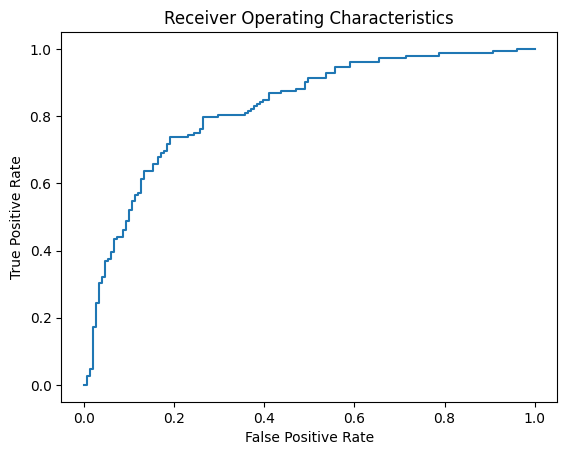

In [189]:
df = df.dropna()
df = df[~(df == .5).any(axis=1)]
print(len(df))
# df = df[~(df == -20).any(axis=1)]
df = df[(df['tourney_level'] == 6)]
# df = df[(df['surface_Hard'] == 1.0)]

# df = df.drop(df.columns[df.columns.str.contains('_rd')], axis=1)

odds_df = df[['a_odds', 'b_odds']].copy()
odds_df['index'] = df.index

df = df.drop(columns=['a_odds', 'b_odds'])

y = df['a_b_win'].values
X = df.drop('a_b_win', axis=1).values

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, odds_df['index'].values, test_size=0.2, random_state=42
)

# Set target accuracy# Set target AUC# Set target AUC
# Set target AUC
target_auc = 0.825

final_auc = 0.0
final_acc = 0.0
while final_auc < target_auc:
    best_auc, best_acc, best_model_weights = cross_validate(OutcomeProbabilityV6, X_train, y_train, epochs=100, target_auc=target_auc)
    print(f"Best cross-validated AUC: {best_auc:.4f}")
    print(f"Best cross-validated accuracy: {best_acc*100:.2f}%")

    # Final training on full training data
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
    val_data = TensorDataset(X_test_tensor, y_test_tensor)
    val_loader = DataLoader(val_data, batch_size=128, shuffle=False)

    model = OutcomeProbabilityV6(input_dim=X.shape[1])
    model.load_state_dict(best_model_weights)
    final_auc, final_acc, _ = train_and_evaluate(model, train_loader, val_loader, epochs=100, target_auc=target_auc)
    print(f"Final model AUC on test set: {final_auc:.4f}")
    print(f"Final model accuracy on test set: {final_acc*100:.2f}%")

    if final_auc < target_auc:
        print(f"AUC {final_auc:.4f} not met, restarting the process.")
    # Quick train break
    # break



# Evaluate and store predictions
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()
    y_test_np = y_test_tensor.numpy()
    odds_test = odds_df.loc[idx_test].values

    # Create DataFrame with predictions and actual values
    results_df = pd.DataFrame({
        'Actual': y_test_np.flatten(),
        'Predicted': y_pred.flatten(),
        'A_Odds': odds_test[:, 0],
        'B_Odds': odds_test[:, 1]
    })

    # Optionally save to CSV
    results_df.to_csv('predictions_with_odds.csv', index=False)

# Plot ROC curve
with torch.no_grad():
    fpr, tpr, thresholds = roc_curve(y_test_tensor, y_pred)
    plt.plot(fpr, tpr)
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

In [190]:
# Display the DataFrame
# results_df.head()
print(results_df)

     Actual  Predicted  A_Odds  B_Odds
0       0.0   0.106825   13.40    1.02
1       0.0   0.627703    2.39    1.56
2       0.0   0.559063    2.33    1.60
3       1.0   0.673873    1.70    2.13
4       0.0   0.039891   12.24    1.04
..      ...        ...     ...     ...
298     1.0   0.405294    2.02    1.77
299     1.0   0.838449    1.33    3.31
300     1.0   0.594029    1.25    3.94
301     0.0   0.347922    1.96    1.91
302     0.0   0.332293    2.81    1.42

[303 rows x 4 columns]


In [191]:
# Kelly Criterion
def kelly_criterion(vegas_odds, calculated_probability):
    corrected = vegas_odds - 1
    # Calculate the Kelly fraction
    kelly_fraction = calculated_probability - ((1 - calculated_probability)/corrected)
    # Ensure that the fraction is not negative
    kelly_fraction = max(0, kelly_fraction)
    
    return kelly_fraction

In [192]:
better = 0
total_won = 0
diff_fav = 0
bet_correct = 0

upset_predict = 0
upset_correct = 0
upset_won = 0

model_correct = 0
vegas_correct = 0
vegas_total = 0

wrong = 0
comparison_df = results_df.dropna()
length = len(comparison_df)

avg_bet = 0

confidence_pct = .5
confidence_top_pct = 1

START_UNIT = 10
UNIT = START_UNIT

for i, row in comparison_df.iterrows():
    current = START_UNIT
    if confidence_top_pct > row['Predicted'] > confidence_pct :
        kelly = (kelly_criterion(row['A_Odds'], row['Predicted']) * START_UNIT)
        better += 1 if kelly > 0 else 0
        avg_bet += kelly_criterion(row['A_Odds'], row['Predicted'])
        if(row['Actual'] == 1):
            bet_correct += 1 if kelly > 0 else 0
            START_UNIT += (row['A_Odds']-1) * kelly
        else:
            wrong += 1 if kelly > 0 else 0
            START_UNIT -= kelly

    if 1-confidence_top_pct < row['Predicted'] < 1-confidence_pct :
        kelly = (kelly_criterion(row['B_Odds'], 1-row['Predicted']) * START_UNIT)
        better += 1 if kelly > 0 else 0
        avg_bet += kelly_criterion(row['B_Odds'], 1-row['Predicted'])
        if(row['Actual'] == 0):
            bet_correct += 1 if kelly > 0 else 0
            START_UNIT += (row['B_Odds']-1) * kelly
        else:
            wrong += 1 if kelly > 0 else 0
            START_UNIT -= kelly

    if round(row['Predicted']) != round(1/row['A_Odds']):
        kelly_A  = (kelly_criterion(row['A_Odds'],row['Predicted']) * UNIT)
        kelly_B  = (kelly_criterion(row['B_Odds'],1-row['Predicted']) * UNIT)

        upset_predict += 1 if (kelly_A > 0 and round(row['Predicted']) == 1) or (kelly_B > 0 and round(row['Predicted']) == 0) else 0

        if round(row['Predicted']) == round(row['Actual']):
            if(row['Actual'] == 1):
                upset_correct += 1 if kelly_A > 0 else 0
                upset_won += (row['A_Odds']-1) * kelly_A
            else:
                upset_correct += 1 if kelly_B > 0 else 0
                upset_won += (row['B_Odds']-1) * kelly_B
        elif round(row['Predicted']) == 1:
            upset_won -= kelly_A
        else:
            upset_won -= kelly_B
            
    if round(row['Predicted']) != round(1/row['A_Odds']):
        diff_fav += 1

    if row['Actual']==1 and row['A_Odds'] < row['B_Odds']:
        # print(f"A odds : {row['a_odds']} B odds : {row['b_odds']}")
        vegas_correct += 1

    if row['Actual']==0 and row['A_Odds'] > row['B_Odds']:
        vegas_correct += 1

    if round(row['Predicted']) == round(row['Actual']):
        model_correct += 1


print(f"Total returned on Starting ${UNIT} bankroll: {START_UNIT:.2f} on a total # bets: {better} from a total of {length} games")
print(f"ROI : {((START_UNIT-UNIT)/UNIT):.1f} X")
print(f"Avg Bankroll Bet % : {(avg_bet/better):.3f} %")
print(f"Amount of differing favorites %: {(diff_fav/length):.3f}")
print(f"Amount of upset bets correct % : {(upset_correct/upset_predict):.3f} with Unit ${UNIT} won ${upset_won:.2f} on {upset_predict} bets")
print(f"Amount of incorrect bet % : {(wrong/better):.4f}")
print(f"Correct Bet %: {(bet_correct/better):.4f}")
print(f"Model % Correct : {(model_correct/length):.4f} Vegas Correct % : {(vegas_correct/length):.4f}")


Total returned on Starting $10 bankroll: 0.62 on a total # bets: 103 from a total of 303 games
ROI : -0.9 X
Avg Bankroll Bet % : 0.247 %
Amount of differing favorites %: 0.109
Amount of upset bets correct % : 0.545 with Unit $10 won $41.16 on 33 bets
Amount of incorrect bet % : 0.4078
Correct Bet %: 0.5922
Model % Correct : 0.7624 Vegas Correct % : 0.7624
